In [110]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# SMOT 
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [32]:
DataSet = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
DataSet.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
DataSet.describe().T
empty_string_count = (DataSet.map(lambda x: x == ' ' or x == '' or x=='  ')).sum()
empty_string_count


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [50]:
# clean the TotalCharges
DataSet_cleaned = DataSet[~DataSet['TotalCharges'].isin([' ', '', '  '])]
DataSet_cleaned.map(lambda x: x == ' ' or x == '' or x=='  ').sum()
DataSet_cleaned = DataSet_cleaned.drop('customerID', axis=1)
DataSet_cleaned['TotalCharges'] = DataSet_cleaned['TotalCharges'].astype(float)
DataSet_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [54]:
label_ = LabelEncoder()

df1 = DataSet.copy(deep = True)
# to select the columns which are not nummerical
text_data_features = [i for i in list(DataSet.columns) if i not in list(DataSet.describe().columns)]
for i in text_data_features :
    df1[i] = label_.fit_transform(df1[i])
    print(i,' : ', df1[i].unique(),' = ', label_.inverse_transform(df1[i].unique()))

customerID  :  [5375 3962 2564 ... 3367 5934 2226]  =  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (aut

In [56]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
customerID,7043.0,3521.000000,2033.283305,0.00,1760.5,3521.00,5281.50,7042.00
gender,7043.0,0.504756,0.500013,0.00,0.0,1.00,1.00,1.00
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
Partner,7043.0,0.483033,0.499748,0.00,0.0,0.00,1.00,1.00
Dependents,7043.0,0.299588,0.458110,0.00,0.0,0.00,1.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
PhoneService,7043.0,0.903166,0.295752,0.00,1.0,1.00,1.00,1.00
MultipleLines,7043.0,0.940508,0.948554,0.00,0.0,1.00,2.00,2.00
InternetService,7043.0,0.872923,0.737796,0.00,0.0,1.00,1.00,2.00
OnlineSecurity,7043.0,0.790004,0.859848,0.00,0.0,1.00,2.00,2.00


In [57]:
df1['PaymentMethod']
"""
    customerID  :  [5375 3962 2564 ... 3367 5934 2226]  =  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
    '3186-AJIEK']
    gender  :  [0 1]  =  ['Female' 'Male']
    Partner  :  [1 0]  =  ['Yes' 'No']
    Dependents  :  [0 1]  =  ['No' 'Yes']
    PhoneService  :  [0 1]  =  ['No' 'Yes']
    MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
    InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
    OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
    OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
    DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
    TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
    StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
    StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
    Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
    PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
    PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
    'Credit card (automatic)']
    TotalCharges  :  [2505 1466  157 ... 2994 2660 5407]  =  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
    Churn  :  [0 1]  =  ['No' 'Yes']
"""

0       2
1       3
2       3
3       0
4       2
       ..
7038    3
7039    1
7040    2
7041    3
7042    0
Name: PaymentMethod, Length: 7043, dtype: int64

In [59]:
# find the unique catrgories in different columns
[len(df1[i].unique()) for i in df1.columns]


[7043, 2, 2, 2, 2, 73, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 1585, 6531, 2]

In [117]:
df1.columns
df1.to_csv("Dataset_after_FeatureEngineering.csv")

In [64]:
# Feathure Engineering

mms = MinMaxScaler() # Normalization
# ss = StandardScaler() # Standardization
df1['tenure'] = mms.fit_transform(df1[['tenure']])
df1['MonthlyCharges'] = mms.fit_transform(df1[['MonthlyCharges']])
df1['TotalCharges'] = mms.fit_transform(df1[['TotalCharges']])
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,0.013889,0,1,0,0,...,0,0,0,0,0,1,2,0.115423,0.383614,0
1,3962,1,0,0,0,0.472222,1,0,0,2,...,2,0,0,0,1,0,3,0.385075,0.224502,0
2,2564,1,0,0,0,0.027778,1,0,0,2,...,0,0,0,0,0,1,3,0.354229,0.024043,1
3,5535,1,0,0,0,0.625000,0,1,0,2,...,2,2,0,0,1,0,0,0.239303,0.214395,0
4,6511,0,0,0,0,0.027778,1,0,1,0,...,0,0,0,0,0,1,2,0.521891,0.141654,1


2024-10-19 22:23:42 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x305511fd0>


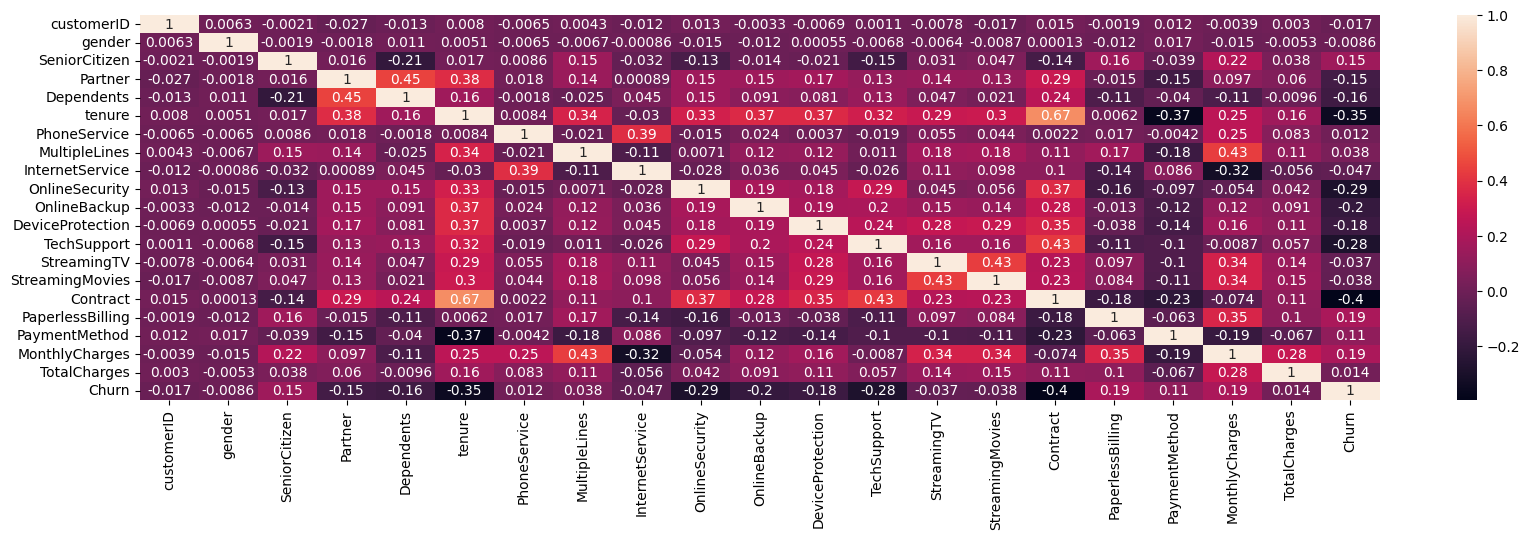

In [75]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),annot = True);

2024-10-19 22:23:39 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x3053fbc40>


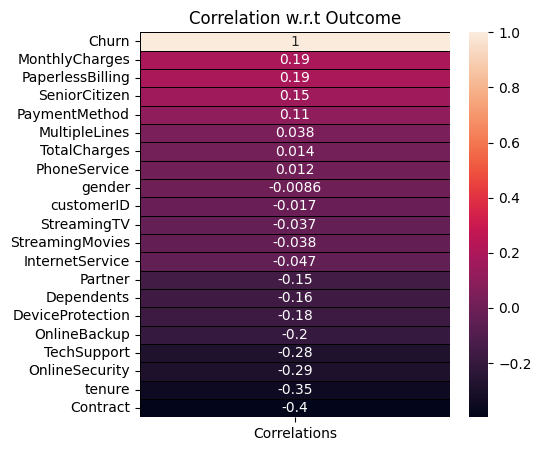

In [74]:
corr = df1.corrwith(df1['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Outcome');

In [78]:
# from catrgorical and nummerical respectively to find the low relatvie variables
df1.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'],inplace = True)
df1.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,1,0,0.013889,0,2,0,0,0,1,2,0.115423,0.383614,0
1,3962,0,0,0,0.472222,2,0,2,0,1,0,3,0.385075,0.224502,0
2,2564,0,0,0,0.027778,2,2,0,0,0,1,3,0.354229,0.024043,1
3,5535,0,0,0,0.625000,2,0,2,2,1,0,0,0.239303,0.214395,0
4,6511,0,0,0,0.027778,0,0,0,0,0,1,2,0.521891,0.141654,1


In [106]:
SMOTE_ = SMOTE(sampling_strategy = 1)

X = df1.iloc[:, :-1].values
Y = df1['Churn'].values
X, Y = SMOTE_.fit_resample(X, Y)
Counter(Y)

Counter({0: 5174, 1: 5174})

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [115]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 2)

def model(classifier, x_train, y_train, x_test, y_test):
    # Fit the model
    classifier.fit(x_train, y_train)
    
    # Make predictions
    prediction = classifier.predict(x_test)
    prediction_proba = classifier.predict_proba(x_test)[:, 1]
    
    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cv_score = cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc')
    print("Cross Validation Score: ", '{0:.2%}'.format(cv_score.mean()))
    
    # ROC AUC score
    print("ROC AUC Score: ", '{0:.2%}'.format(roc_auc_score(y_test, prediction_proba)))
    
    # ROC Curve plot
    RocCurveDisplay.from_estimator(classifier, x_test, y_test)
    plt.title('ROC AUC Plot')
    plt.show()

def model_evaluation(classifier, x_test, y_test):
    # Confusion Matrix
    cm = confusion_matrix(y_test, classifier.predict(x_test))
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    # Heatmap for Confusion Matrix
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print(classification_report(y_test, classifier.predict(x_test)))

Cross Validation Score:  91.05%
ROC AUC Score:  91.74%


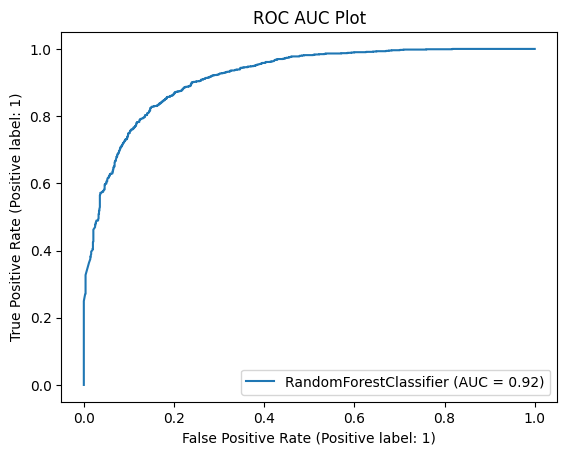

2024-10-19 22:39:01 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x305099ac0>


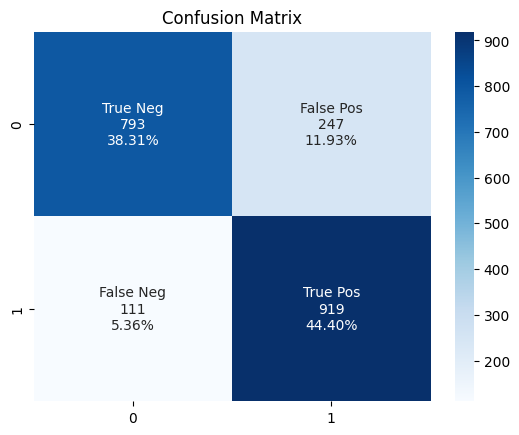

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1040
           1       0.79      0.89      0.84      1030

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



In [116]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
model(classifier_rf,x_train,y_train,x_test,y_test)
model_evaluation(classifier_rf,x_test,y_test)